# Starter

Analysis and training

## Setup

### Import Dependencies

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [51]:
# files and os
import os
import tqdm

# analysis
import numpy
import pandas as pd
import geopandas as gpd
import pysal

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn
from src.utils import *

### Constants and paths

In [488]:
class CFG:
    root_data = './data'

    # train data
    train_files = [
        os.path.join(root_data, 'Kenya_training.csv'),
        os.path.join(root_data, 'Spain_training.csv'),
        os.path.join(root_data, 'VNM_training.csv')
    ]

    # test_data
    test_files = [
        os.path.join(root_data, 'Kenya_testing.csv'),
        os.path.join(root_data, 'Spain_validation.csv'),
        os.path.join(root_data, 'VNM_testing.csv')
    ]

    # sentinel_bands = [
    

## Load and Explore Data

### Load Data

In [30]:
def create_dataset(config, train = True, shuffle = True):    
    if train:
        files = config.train_files
    else:
        files = config.test_files

    dataset = []
    for file in files:
        dataset.append(load_file(file))

    dataset = pd.concat(dataset)

    if shuffle:
        dataset = dataset.sample(frac = 1, replace = False)

    dataset.reset_index(drop = True, inplace = True)
    return dataset

In [590]:
df_train = create_dataset(CFG, train = True)
df_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   location   2825 non-null   object  
 1   id         2825 non-null   object  
 2   lon        2825 non-null   float64 
 3   lat        2825 non-null   float64 
 4   blue_p50   2825 non-null   float64 
 5   green_p50  2825 non-null   float64 
 6   nir_p50    2825 non-null   float64 
 7   nira_p50   2825 non-null   float64 
 8   re1_p50    2825 non-null   float64 
 9   re2_p50    2825 non-null   float64 
 10  re3_p50    2825 non-null   float64 
 11  red_p50    2825 non-null   float64 
 12  swir1_p50  2825 non-null   float64 
 13  swir2_p50  2825 non-null   float64 
 14  vv_p50     2825 non-null   float64 
 15  vh_p50     2825 non-null   float64 
 16  target     2825 non-null   int64   
 17  geometry   2825 non-null   geometry
dtypes: float64(14), geometry(1), int64(1), object(2)
memory usag

### Visualize Data

<Axes: xlabel='target', ylabel='count'>

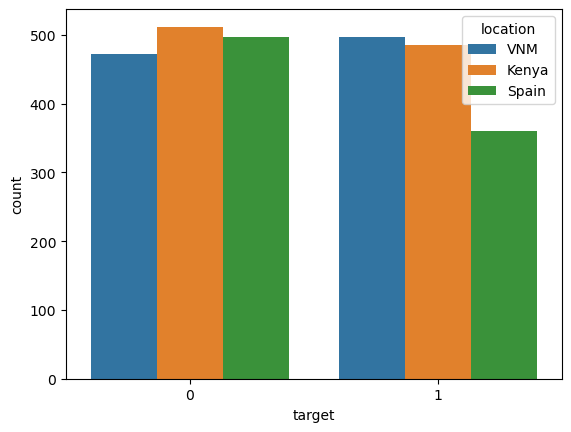

In [33]:
sns.countplot(df_train, x = 'target', hue = 'location')

In [72]:
df_temp = df_train.drop(columns = ['location', 'id', 'lon', 'lat', 'target', 'geometry'])

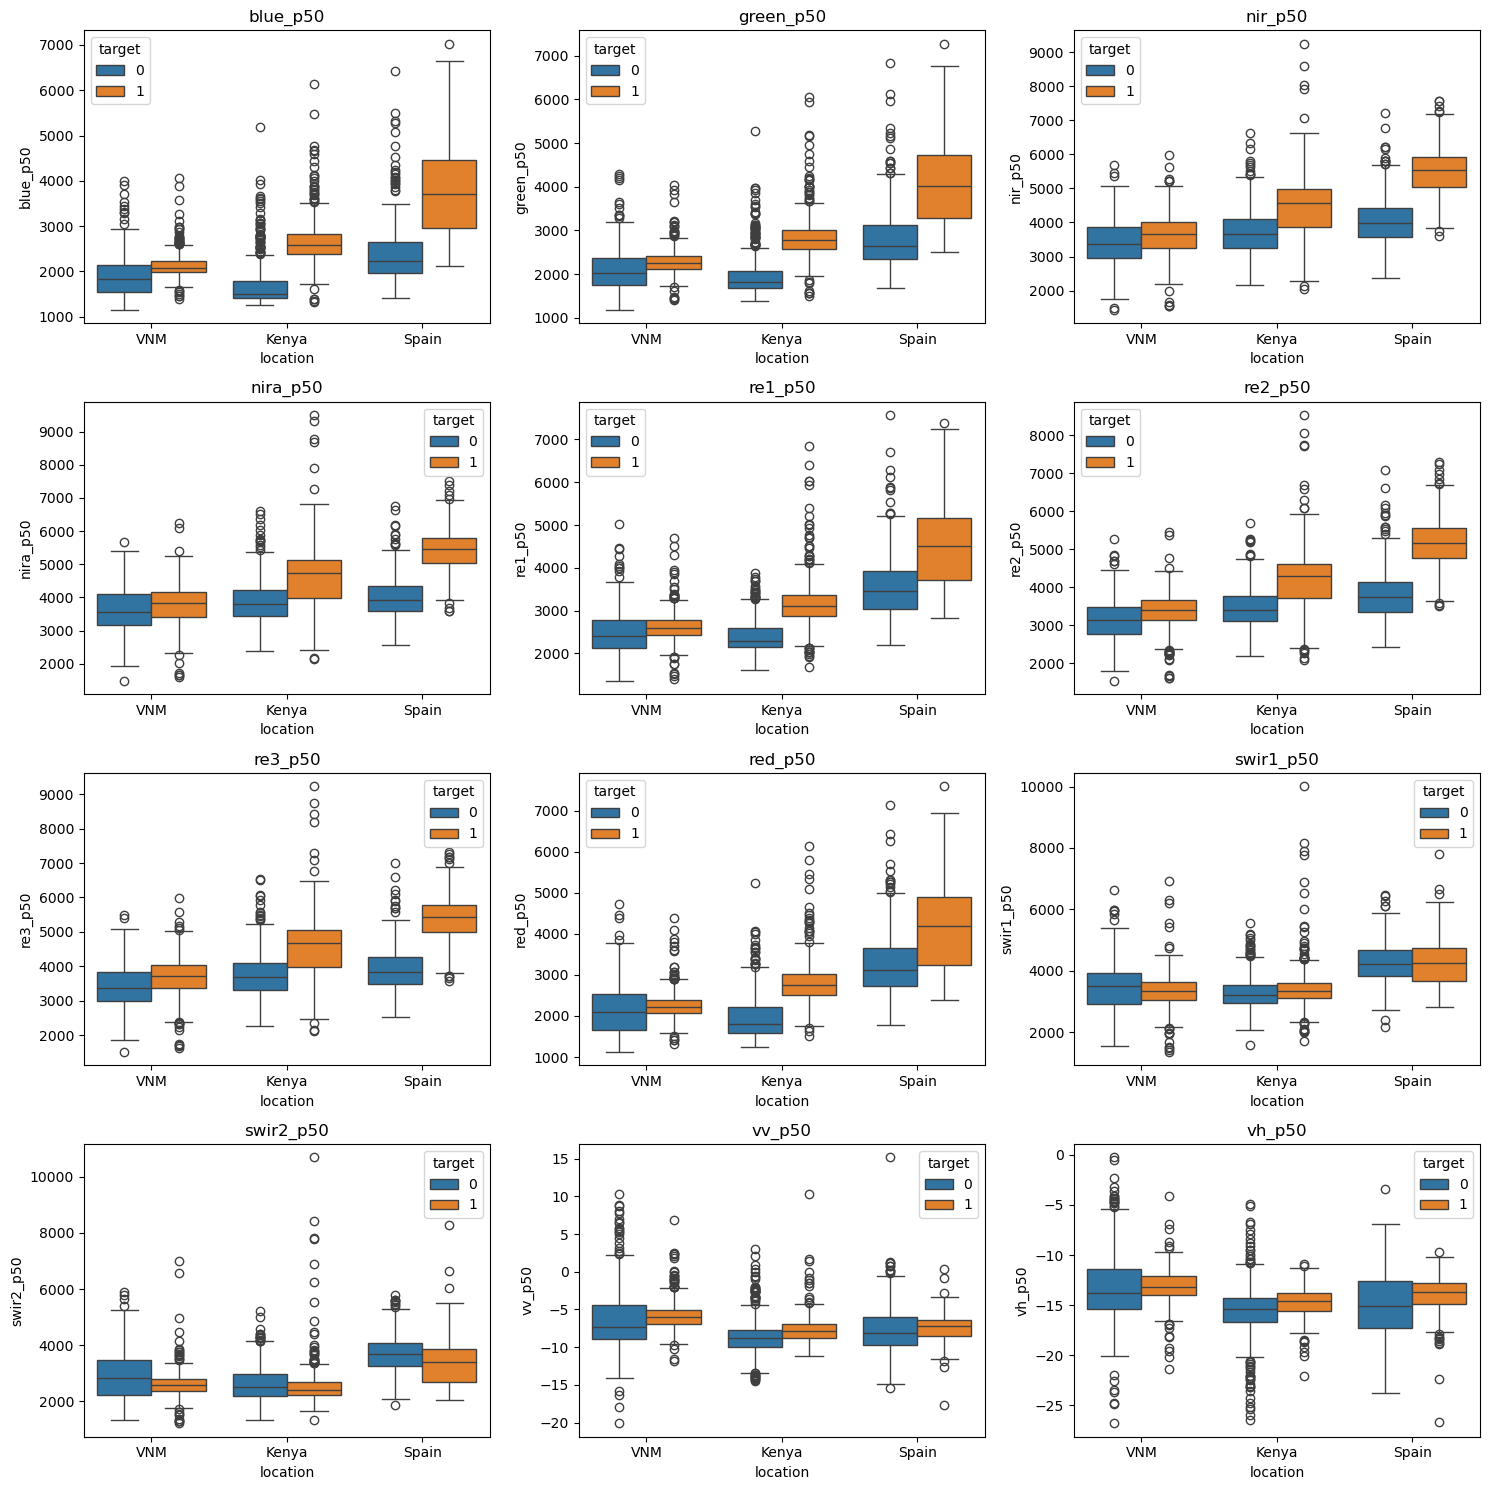

In [82]:
fig, ax = plt.subplots(4, 3, figsize = (15, 15))
ax = ax.flatten()
cols = df_temp.columns
for i in range(len(ax)):
    sns.boxplot(df_train, x = 'location', y = cols[i], hue = 'target', ax = ax[i]) 
    ax[i].set_title(cols[i])
plt.tight_layout();

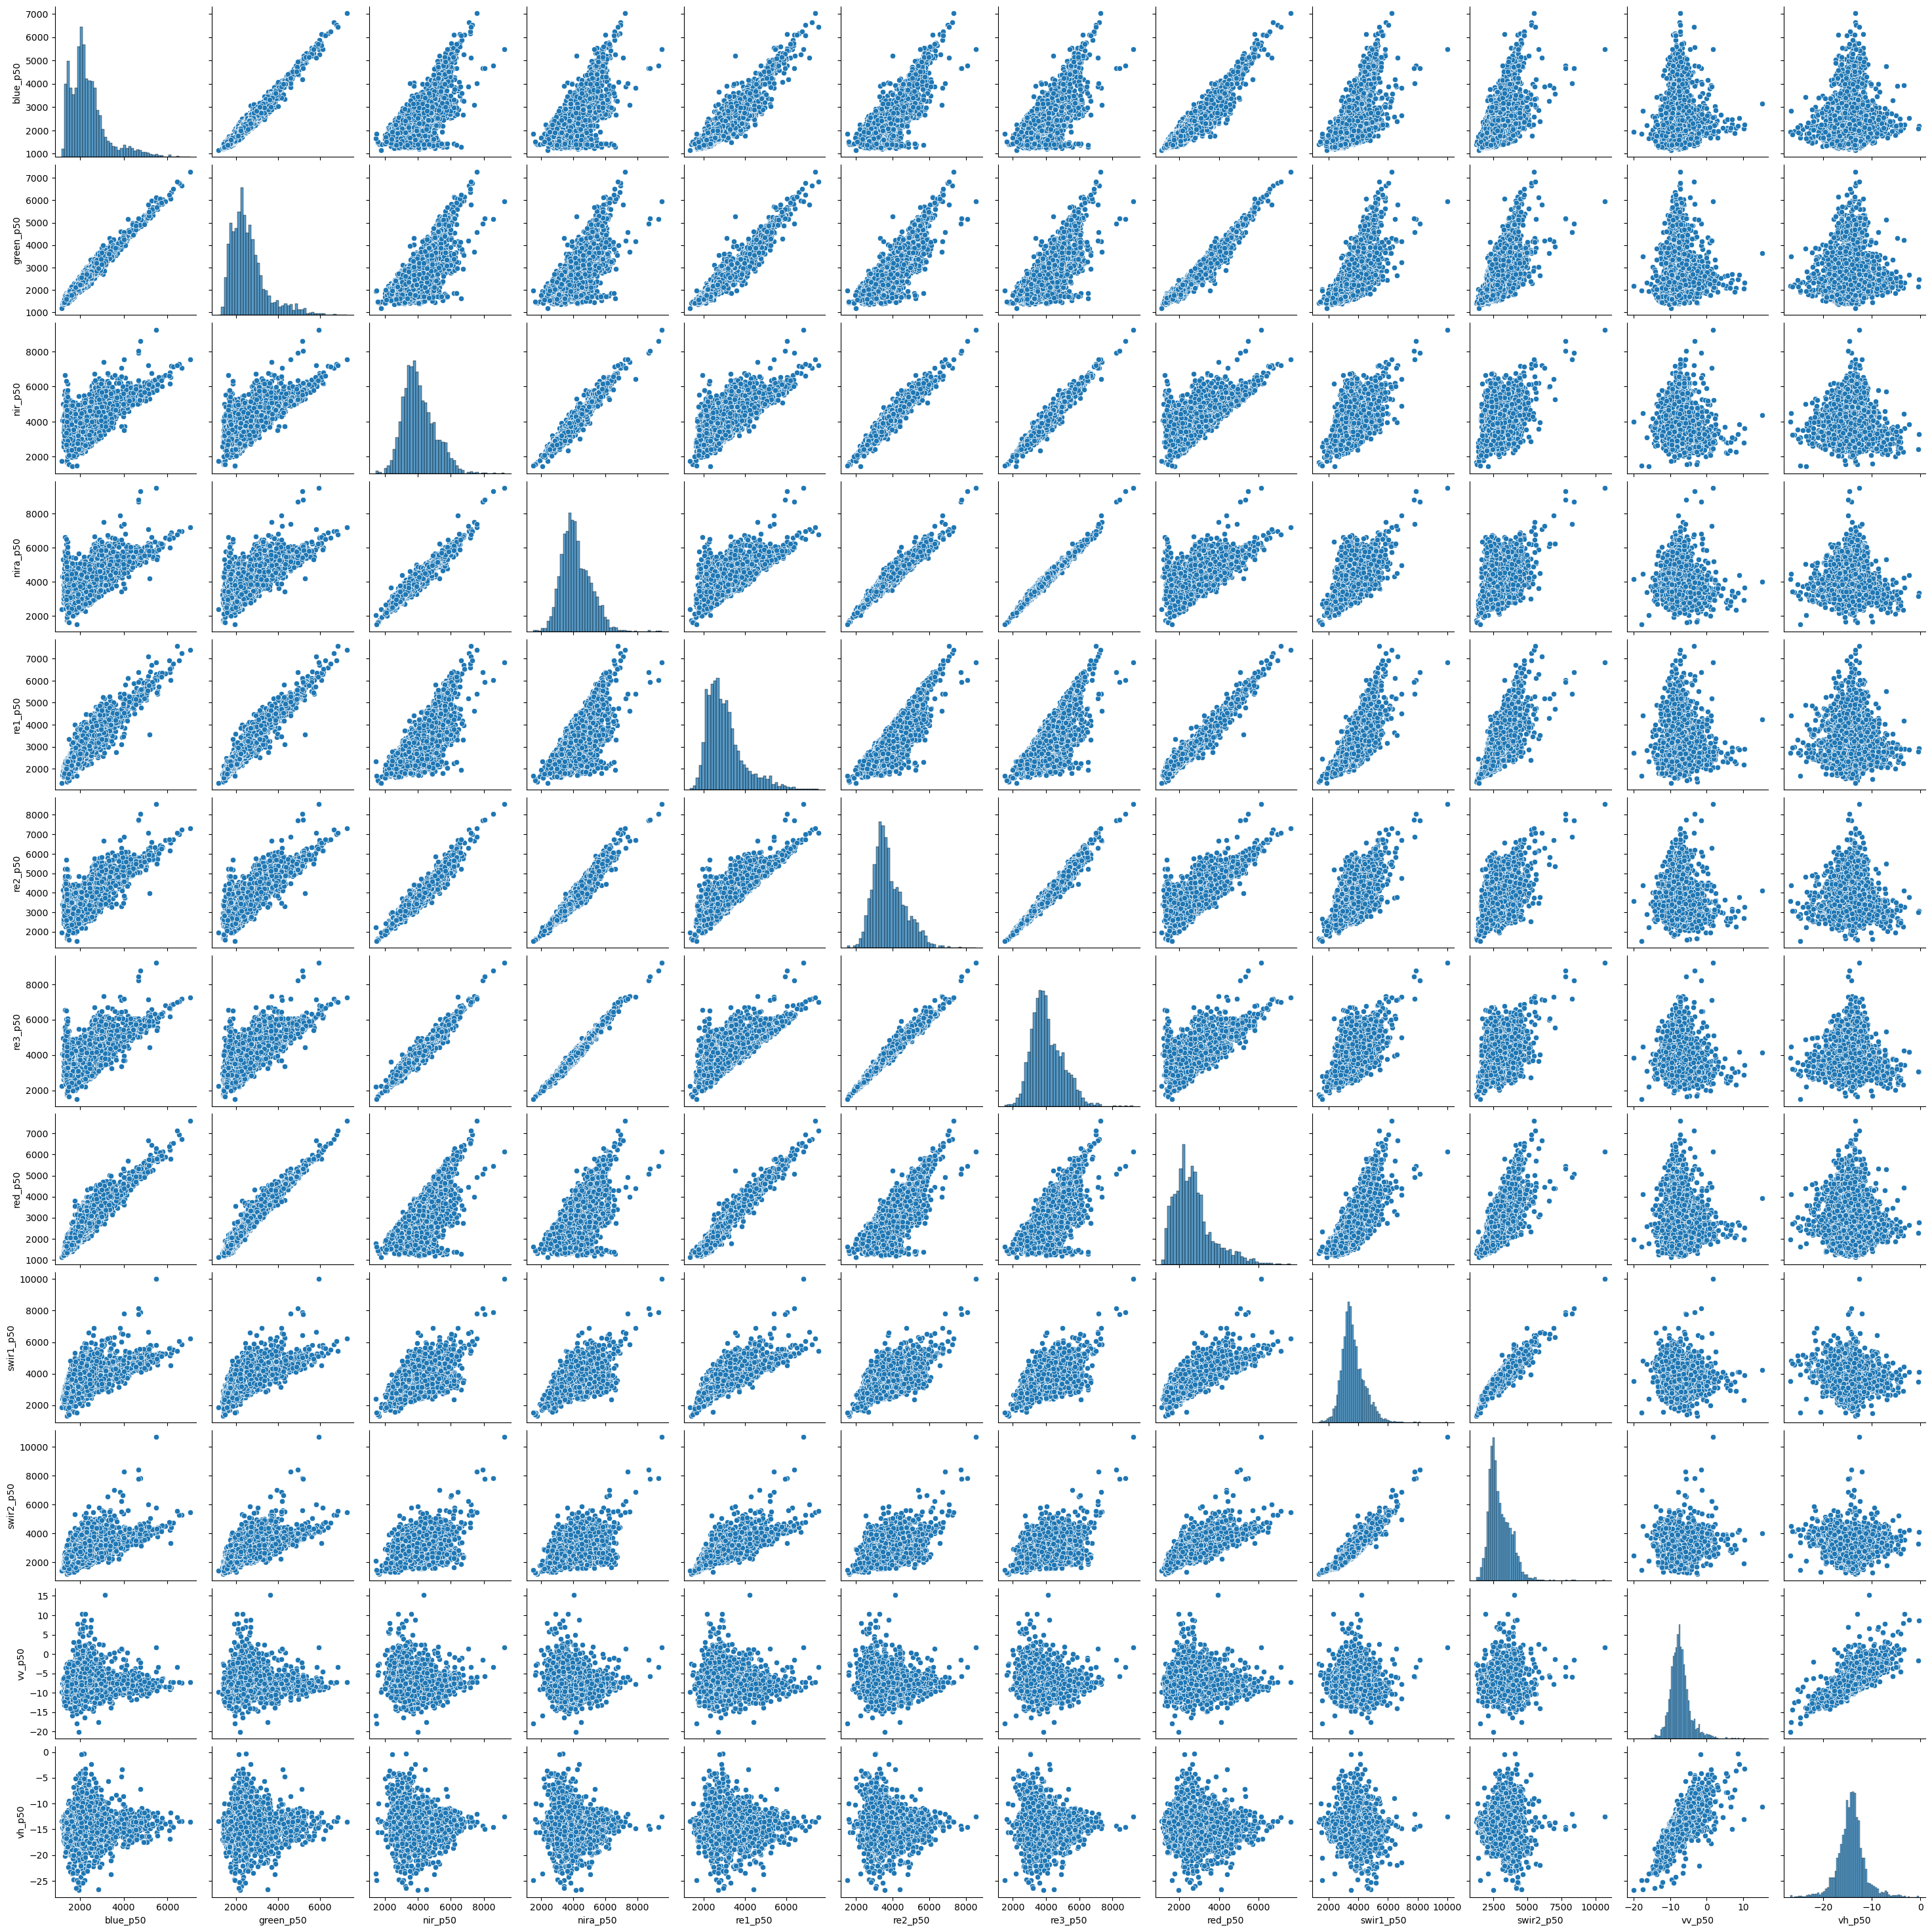

In [77]:
sns.pairplot(df_temp);

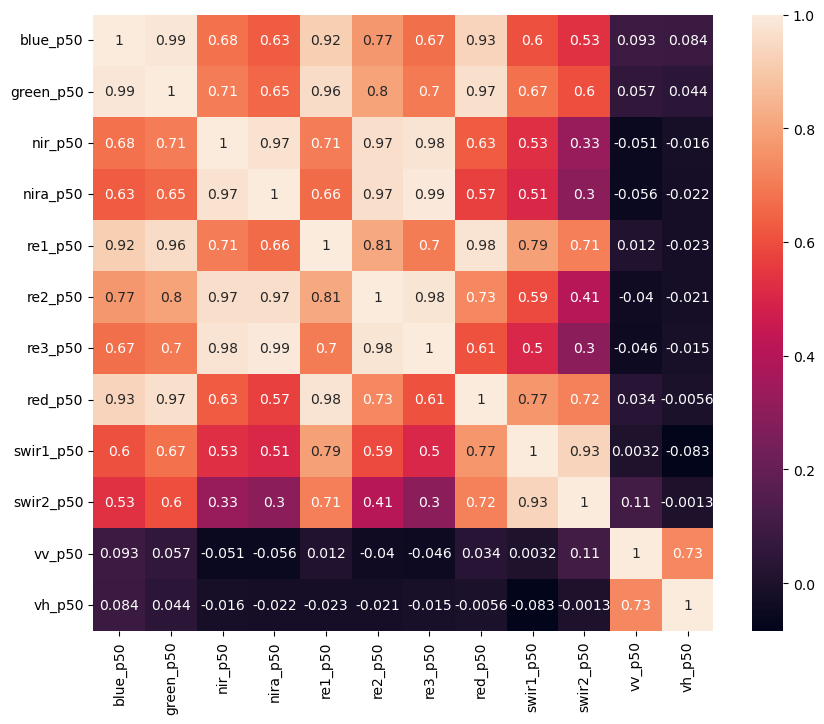

In [73]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(df_temp.corr(), annot = True, ax = ax);

### Feature Engineering

In [1108]:
def engineer_features(df):
    df = df.copy()
    # PCI
    df['pci'] = df.blue_p50 / df.swir2_p50
    
    # NDVI
    df['ndvi'] = (df.nir_p50 - df.red_p50) / (df.nir_p50 + df.red_p50)

    # NDWI
    df['ndwi'] = (df.green_p50 - df.nir_p50) / (df.green_p50 + df.nir_p50)

    # BSI - Bare Soil Index
    df['bsi'] = ((df.swir1_p50 + df.red_p50) - (df.nir_p50 - df.blue_p50)) / ((df.swir1_p50 + df.red_p50) + (df.nir_p50 + df.blue_p50))

    # NDSI
    df['ndsi'] = (df.green_p50 - df.swir1_p50) / (df.green_p50 + df.swir1_p50)

    # # NDRE
    # df['ndre'] = (df.nir_p50 - df.re1_p50) / (df.nir_p50 + df.re1_p50)

    # Grey
    df['grey'] = 0.2989 * df.red_p50 + 0.5870 * df.green_p50 + 0.1140 * df.blue_p50
    df['greyness'] = 1 - (abs(df.red_p50 - df.grey) + abs(df.green_p50 - df.grey) + abs(df.blue_p50 - df.grey))/ 10000
 
    # # False Color
    # df['false_color'] = df.green_p50 + df.blue_p50 + df.nir_p50

    # # True Color
    # df['true_color'] = df.green_p50 + df.blue_p50 + df.red_p50

    # #  Moisture
    # df['moisture'] = (df.nira_p50 - df.swir1_p50) / (df.nira_p50 + df.swir1_p50)

    # # Polarisation
    df['polarisation'] = df.vv_p50 + df.vh_p50

    # # RVI
    df['rvi'] = 4 * df.vv_p50 / df.polarisation

    # Polar Angle
    df['p_angle'] = df.vv_p50 / df.vh_p50

    # diff
    df['swir_diff'] = abs(df.swir2_p50 - df.swir1_p50)
    df['swir_add'] = np.sqrt(df.swir2_p50**2 + df.swir1_p50**2)
    df['swir_ratio'] = df.swir1_p50 / df.swir2_p50
    df['rgb_add'] = np.sqrt(df.red_p50**2 + df.blue_p50**2 + df.green_p50**2)
    df['bg_diff'] = abs(df.blue_p50 - df.green_p50)
    df['bg_ratio'] = df.blue_p50 / df.green_p50
    df['nir_swir_ratio'] = df.nir_p50 / df.swir1_p50
    df['re_diff'] = df.re1_p50 - (df.re2_p50 + df.re3_p50) / 2
    df['re_nir_ratio'] = df.re1_p50 / df.nir_p50

     # Spatial Lags
    # wq =  lps.weights.Queen.from_dataframe(df)
    wq = lps.weights.KNN.from_dataframe(df)
    wq.transform = 'r'
    df['pci_lag']= lps.weights.lag_spatial(wq, df['pci'])
    df['blue_lag']= lps.weights.lag_spatial(wq, df['blue_p50'])
    df['swir_lag']= lps.weights.lag_spatial(wq, df['swir2_p50'])
    df['bg_lag']= lps.weights.lag_spatial(wq, df['bg_ratio'])
    df['nir_swir_lag']= lps.weights.lag_spatial(wq, df['nir_swir_ratio'])
    df['rvi_lag'] = lps.weights.lag_spatial(wq, df['rvi'])
    df['ndsi_lag'] = lps.weights.lag_spatial(wq, df['ndsi'])

    # # LBP - Blue, SWIR2
    df['pci_lbp'] = df.pci - df.pci_lag
    df['blue_lbp'] = df.blue_p50 - df.blue_lag
    df['swir_lbp'] = df.swir1_p50 - df.swir_lag
    return df

In [943]:
import libpysal as lps

In [944]:
df_feats = engineer_features(df_train)

/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 143 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


<Axes: xlabel='location', ylabel='pci_lag'>

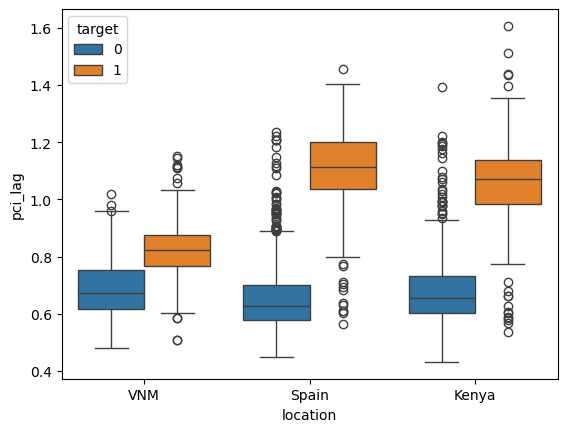

In [945]:
sns.boxplot(df_feats, x = 'location', y = 'pci_lag', hue = 'target')
# plt.ylim(-5, 5)

In [931]:
df_temp = df_feats.drop(columns = ['location', 'id', 'target', 'geometry'])

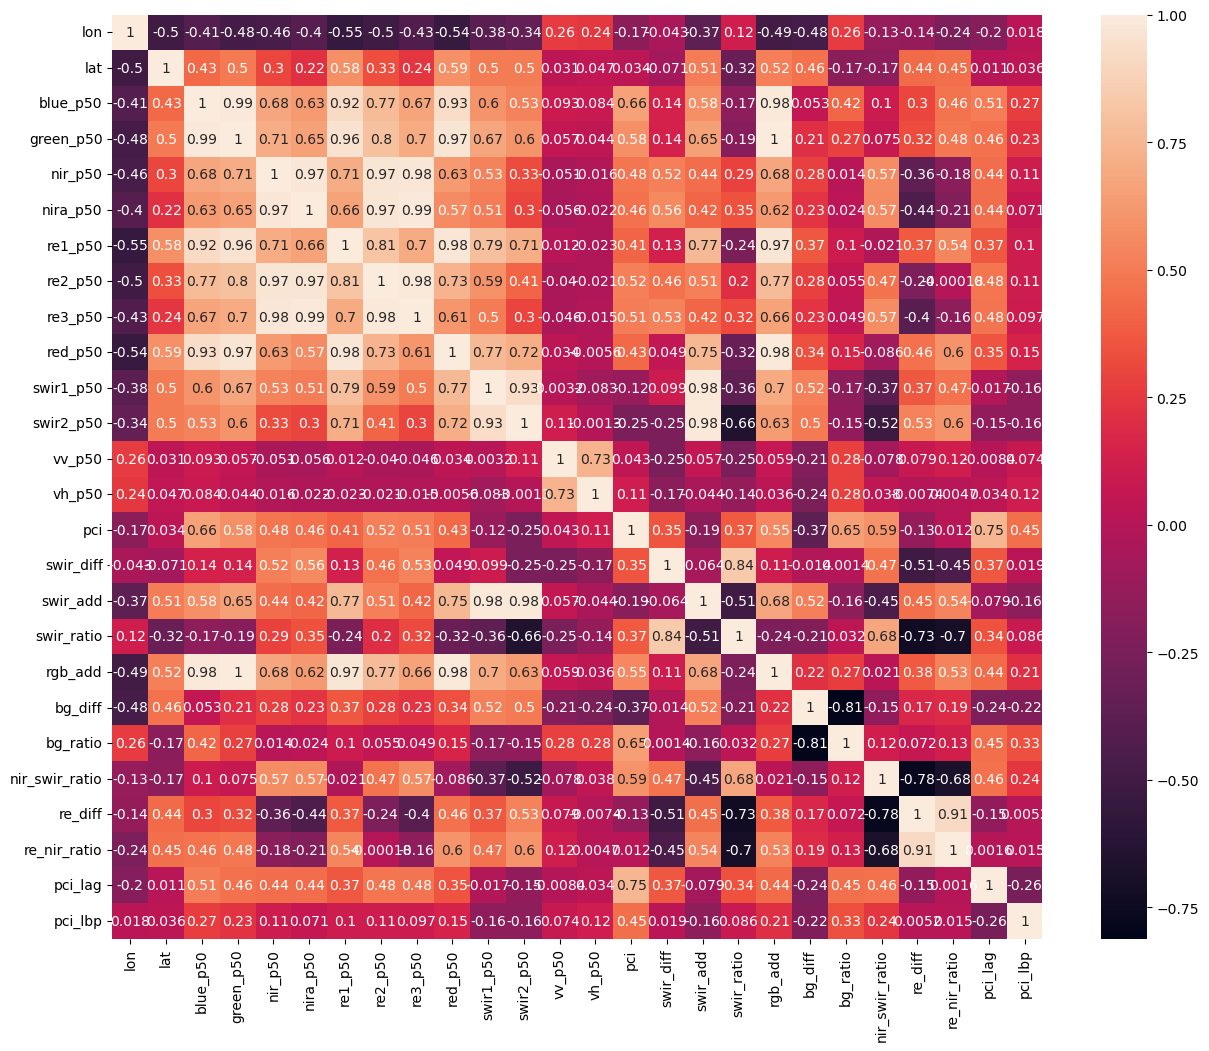

In [932]:
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(df_temp.corr(), annot = True, ax = ax);

In [1329]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans

In [1139]:
data = df_feats.drop(columns = ['id', 'location', 'target', 'geometry'])#, *df.columns])
target = df_feats.target

In [1330]:
dbscan = KMeans(100) #HDBSCAN(min_cluster_size = 3) #DBSCAN(min_samples = 2, eps = 0.02)
dbscan.fit(data[['lat', 'lon']])

KMeans(n_clusters=100)

In [1331]:
n_cluster = len(set(dbscan.labels_))
n_cluster

100

In [1355]:
df_train['cluster'] = dbscan.labels_
df_train['cluster'] = df_train.cluster.astype('category')

<Axes: >

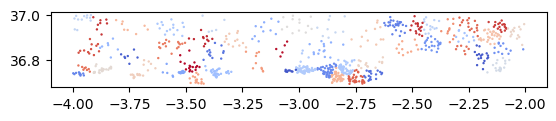

In [1357]:
df_train[df_train.id.str.contains(location)].plot('cluster', markersize = 0.5, cmap = 'coolwarm')

<Axes: >

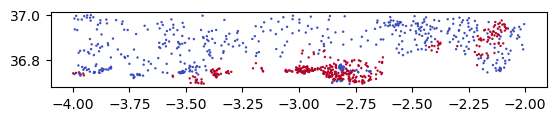

In [1358]:
df_train[df_train.id.str.contains(location)].plot('target', markersize = 0.5, cmap = 'coolwarm')

In [1404]:
data['loc_cluster'] = dbscan.predict(data[['lat', 'lon']])

In [1405]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [1406]:
data_rfe = data.copy()
min_features_to_select = 1  # Minimum number of features to consider
# clf = LogisticRegression(max_iter = 1000)
clf = XGBClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

rfecv.fit(data_rfe, target)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 21


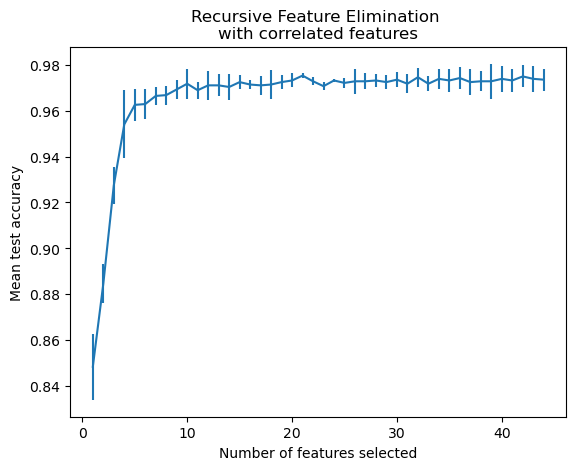

In [1407]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [1402]:
rfecv.ranking_, rfecv.feature_names_in_

(array([ 1,  1,  1,  1, 12,  3, 11,  2,  1,  5, 21,  1,  4, 10,  1, 18, 20,
        16,  1,  1,  1,  1, 23, 19,  1,  8,  1,  1,  9,  1,  1,  7, 17,  1,
         1,  1,  1,  1, 22,  1,  6, 14, 15, 13]),
 array(['lon', 'lat', 'blue_p50', 'green_p50', 'nir_p50', 'nira_p50',
        're1_p50', 're2_p50', 're3_p50', 'red_p50', 'swir1_p50',
        'swir2_p50', 'vv_p50', 'vh_p50', 'pci', 'ndvi', 'ndwi', 'bsi',
        'ndsi', 'grey', 'greyness', 'polarisation', 'rvi', 'p_angle',
        'swir_diff', 'swir_add', 'swir_ratio', 'rgb_add', 'bg_diff',
        'bg_ratio', 'nir_swir_ratio', 're_diff', 're_nir_ratio', 'pci_lag',
        'blue_lag', 'swir_lag', 'bg_lag', 'nir_swir_lag', 'rvi_lag',
        'ndsi_lag', 'pci_lbp', 'blue_lbp', 'swir_lbp', 'loc_cluster'],
       dtype=object))

In [1408]:
select_cols = rfecv.feature_names_in_[rfecv.ranking_ <= 10]
select_cols

array(['lon', 'lat', 'blue_p50', 'green_p50', 'nir_p50', 'nira_p50',
       're1_p50', 're2_p50', 're3_p50', 'swir1_p50', 'vv_p50', 'vh_p50',
       'pci', 'ndwi', 'ndsi', 'greyness', 'polarisation', 'p_angle',
       'swir_diff', 'swir_ratio', 'bg_ratio', 'nir_swir_ratio',
       're_nir_ratio', 'pci_lag', 'blue_lag', 'bg_lag', 'nir_swir_lag',
       'rvi_lag', 'ndsi_lag', 'loc_cluster'], dtype=object)

In [1409]:
train_data = data[select_cols]
train_data = train_data.drop(columns = ['loc_cluster'])

In [1410]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size = 0.2, random_state = 0)

In [1414]:
clf_knn = Pipeline([
    ('loc', ColumnTransformer([('loc_selector', 'passthrough', [0, 1])])),
    ('knn_inner', KNeighborsClassifier(5))
])

clf_lr = LogisticRegression(max_iter = 2000)

clf_rf = RandomForestClassifier(200, max_depth = 10)

clf_xgb = XGBClassifier(n_estimators = 100, enable_categorical = True, eta = 0.1, colsample_bytree = 0.2, random_state = 0)

clf_lgbm = LGBMClassifier(n_estimators = 2, reg_alpha = 1, reg_lambda = 1, learning_rate = 0.1, colsample_bytree = 0.5, random_state = 0)

clf_cbgbm = CatBoostClassifier(n_estimators = 200, l2_leaf_reg = 10, depth = 10, learning_rate = 0.1, rsm = 0.5, random_state = 0)


clf = Pipeline([
    ('scaler', StandardScaler()),
    # ('loc_transformer', ColumnTransformer([('enc', LabelEncoder(), [X_train.shape[1]])], remainder = 'passthrough')),
    ('sc_clf', StackingClassifier(
        estimators = [('knn', clf_knn)],
        final_estimator = VotingClassifier(
            [('clf_rf', clf_rf), ('clf_xgb', clf_xgb), ('clf_lgbm', clf_lgbm), ('clf_cbgbm', clf_cbgbm)],
            voting = 'soft'
        ),
        passthrough = True
    )) 
])

clf
clf.fit(X_train, y_train)
clf.score(X_test, y_test), cross_val_score(clf, data, target)

[LightGBM] [Info] Number of positive: 1085, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7401
[LightGBM] [Info] Number of data points in the train set: 2260, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480088 -> initscore=-0.079688
[LightGBM] [Info] Start training from score -0.079688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	learn: 0.5579933	total: 93.4ms	remaining: 18.6s
1:	learn: 0.4636447	total: 122ms	remaining: 12.1s
2:	learn: 0.3883802	total: 137ms	remaining: 9.03s
3:	learn: 0.3242908	total: 157ms	remaining: 7.68s
4:	learn: 0.2682045	total: 173ms	remaining: 6.75s
5:	learn: 0.2316195	total: 190ms	remaining: 6.14s
6:	learn: 0.1980211	total: 207ms	remaining: 5.72s
7:	learn

(0.9769911504424779,
 array([0.97168142, 0.97522124, 0.98053097, 0.98230088, 0.98584071]))

## Submission

In [1434]:
df_test = create_dataset(CFG, train = False, shuffle = False)
df_test_feats = engineer_features(df_test)
df_test_feats['loc_cluster'] = dbscan.predict(df_test_feats[['lat', 'lon']])
test_data = df_test_feats[select_cols]#.drop(columns = ['location', 'id', 'geometry'])#, *df_test.columns])
test_data = test_data.drop(columns = ['loc_cluster'])

/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 176 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [1435]:
clf.predict(X_train).shape

(2260,)

In [1436]:
submission = df_test[['id']]

In [1437]:
submission['target'] = clf.predict(test_data)

/tmp/ipykernel_1925292/1921893077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['target'] = clf.predict(test_data)


In [1438]:
submission.target = np.where(submission.target == 0, 2, 1)
submission.columns = [x.upper() for x in submission.columns]

/tmp/ipykernel_1925292/148986286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.target = np.where(submission.target == 0, 2, 1)


In [1439]:
submission.to_csv('Submission11.csv', index = False)